# Problem 3 - a simple 2D distribution

Here we will make some data for a population of stars but we will make the stellar luminosity a funciton of mass.  We will make the data look like the luminosity (or absolute magnitude) of the red clump as a function of mass (where the gradient is choosen to suit this problem not the real world).

First we make some true mass values for the stars:

$M_{\rm true} \sim \mathcal{N}(1.0, 0.1)$ 

The distribution of the K-band Magnitufe of the red clump will be defined as:

$K_{\rm RC} \sim \mathcal{N}(-1.61 + ((M - 1)/ 3), 0.03)$.

For now, assume we have some magic machine that measures stellar absolute magnitudes in the K band with an observational uncertainty of 0.05 magnitudes.  If we have $N$ stars which we will label with the index $i = 1,2,..., N$ then the measured magnitude will be:

$K_{i, {\rm obs}} \sim \mathcal{N}(K_{i, {\rm true}}, 0.05)$.

and finally we have the observed mass with the mass uncertainty as $0.05 \, \rm M_{\odot}$: 

$M_{\rm obs} = \mathcal{N}(M_{\rm true}, 0.05)$

Let's set up this data.

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


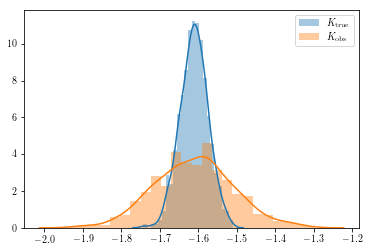

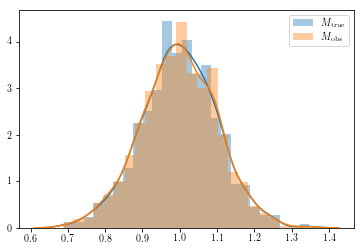

In [72]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

N = 1000
Mm = 1.0
Ms = 0.1
RCS = 0.03
alpha = -1.61
betainv = 1.0/5.0
M_true = np.random.randn(N) * Ms + Mm
K_true = np.random.randn(N) * RCS + (alpha + ((M_true - 1)*betainv))
sigma_K_obs = np.ones(N) * 0.1
K_obs = K_true + np.random.randn(N) * sigma_K_obs
sigma_M_obs = np.ones(N) * 0.01
M_obs = M_true + np.random.randn(N) * sigma_M_obs                                     
ax = sns.distplot(K_true, label=r'$K_{\rm true}$')
ax = sns.distplot(K_obs, label=r'$K_{\rm obs}$')
ax.legend()
plt.show()
ax = sns.distplot(M_true, label=r'$M_{\rm true}$')
ax = sns.distplot(M_obs, label=r'$M_{\rm obs}$')
ax.legend()

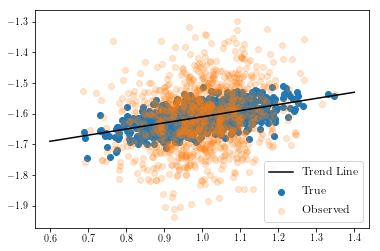

In [73]:
fig, ax = plt.subplots()
from matplotlib import rc
rc("font", family="serif", size=12)
ax.scatter(M_true, K_true, label='True')
ax.scatter(M_obs, K_obs, alpha=0.2, label='Observed')
MM = np.linspace(0.6, 1.4, 100)
ax.plot(MM, alpha + (MM - 1) * betainv, 'k-', label='Trend Line')
ax.legend()

It is immediately obvious, that if we were to try an estimate the spread of K-band Magnitudes for the red clump from the observed data just by measuring the standard deviation we would find an overestimate and would not get any information about the mass dependence.

In [74]:
print(f'Observed data: mean = {K_obs.mean():.4f}; std = {K_obs.std(ddof=1):.4f}; ' + 
      f'error on mean = {K_obs.std(ddof=1) / N**0.5:.4f}')
print(f'True data: mean = {K_true.mean():.4f}; std = {K_true.std(ddof=1):.4f};  ' +
      f'error on mean = {K_true.std(ddof=1) / N**0.5:.4f}')
print(f'Actual spread around the Mass relation {RCS}')

Observed data: mean = -1.6112; std = 0.1026; error on mean = 0.0032
True data: mean = -1.6110; std = 0.0363;  error on mean = 0.0011
Actual spread around the Mass relation 0.03


What we want is a method that takes the observed data and estimates the spread in the true data.  I guess this can be done a number of ways but here we will look at an HBM using latent variables.  

Let's jump right in a build an acyclic graph to visualise our problem:

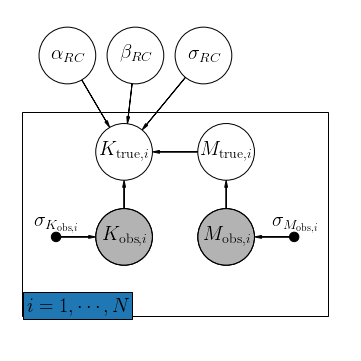

In [34]:
from matplotlib import rc
rc("font", family="serif", size=20)
rc("text", usetex=True)
import daft
pgm = daft.PGM([3,3], grid_unit=4, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("alpha", r"$\alpha_{RC}$", 0.5, 2.6))
pgm.add_node(daft.Node("beta", r"$\beta_{RC}$", 1.1, 2.6))
pgm.add_node(daft.Node("sigma", r"$\sigma_{RC}$", 1.7, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("K_true", r"$K_{{\rm true},i}$", 1, 1.75))
pgm.add_node(daft.Node("M_true", r"$M_{{\rm true},i}$", 1.9, 1.75))
# Data.
pgm.add_node(daft.Node("K_obs", r"$K_{{\rm obs},i}$", 1, 1, observed=True))
pgm.add_node(daft.Node("Kerr", r"$\sigma_{K_{{\rm obs},i}}$", 0.4, 1.0, fixed=True, offset=[0.0,0.4]))
pgm.add_node(daft.Node("M_obs", r"$M_{{\rm obs},i}$", 1.9, 1, observed=True))
pgm.add_node(daft.Node("Merr", r"$\sigma_{M_{{\rm obs},i}}$", 2.5, 1.0, fixed=True, offset=[0.0,0.4]))
# Add in the edges.
pgm.add_edge("alpha", "K_true")
pgm.add_edge("beta", "K_true")
pgm.add_edge("sigma", "K_true")
pgm.add_edge("M_true", 'K_true')
pgm.add_edge("M_obs", "M_true")
pgm.add_edge("Merr", "M_obs")
pgm.add_edge("K_obs", "K_true")
pgm.add_edge("Kerr", "K_obs")
# And a plate.
pgm.add_plate(daft.Plate([0.1, 0.4, 2.7, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

The red clump K-band Magnitudes are assumed to follow a mass relation with a spread frmo a Gaussian distribution.  The parameters for the relation and the spread are unknown.  Each star in $N$ has an index $i$.  Each star also has a true Magnitude and true Mass, which are an unknown, and an observed Magnitude and observed Mass which are known with some uncertainty $\sigma_{K_{{\rm obs},i}}$, and $\sigma_{M_{{\rm obs},i}}$.  We then treat $\alpha$, $\beta$, $\sigma$, , $[K_{{\rm true}, 1}, K_{{\rm true}, 2}, ..., K_{{\rm true}, N}]$, and $[M_{{\rm true}, 1}, M_{{\rm true}, 2}, ..., M_{{\rm true}, N}]$ as parameters that are to be estimated.  

We have the following constraints:

$K_{\rm true} \sim \mathcal{N}(K_{\rm obs}, \sigma_{K_{{\rm obs}}})$.

$M_{\rm true} \sim \mathcal{N}(M_{\rm obs}, \sigma_{M_{{\rm obs}}})$.

That is, the true values of the clump K-band magnitude must be consistent with the observed values and their uncertainties.

$K_{\rm true} \sim \mathcal{N}(\alpha + (M_true - 1)/\beta, \sigma)$.

Which is to say, that the distribution of $K_{\rm true}$ should be consistent with a normal distribution with mean $\mu$ and standard deviation $\sigma$.

We will also add the following priors that represent our exisitng knowledge of the red clump but are designed to be weakly informative:

$\alpha \sim \mathcal{N}{-1.61, 0.5}$,

$\beta \sim \mathcal{N}(0, 10)$,

and 

$\sigma \sim \mathcal{N}(0, 0.5)$,

with a lower limit on sigma of $0$.  

We can code this up in stan easily!

In [60]:
code = '''
data {
    int N;  // N stars
    real Kobs[N];
    real sigmaKobs[N];
    vector[N] Mobs;
    real sigmaMobs[N];
}
parameters {
    real alpha;
    real<lower = 0> beta;
    real<lower = 0> sigma;
    real Ktrue[N];
    vector[N] Mtrue;
}
model {
    Ktrue ~ normal(Kobs, sigmaKobs);
    Ktrue ~ normal(alpha + ((Mtrue - 1.0) / beta), sigma);
    Mtrue ~ normal(Mobs, sigmaMobs);
    alpha ~ normal(-1.61, 0.5);
    beta ~ normal(0, 10.0);
    sigma ~ lognormal(log(0.03), 0.4);
}

'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_67d6f776d0cac7f1a2c296f34267a77a NOW.


We can now run the code.

In [80]:
nchains = 4
data = {'N': N,
       'Kobs': K_obs,
       'sigmaKobs': sigma_K_obs,
       'Mobs': M_obs,
       'sigmaMobs': sigma_M_obs}
fit = sm.sampling(data=data, iter=10000, chains=nchains, pars=['alpha', 'beta', 'sigma'])

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Running the code is simple.  

You can watch the fit proceed in the terminal window.  Running on my laptop, the fit took 20 seconds.

We can print the fit object to see lots of useful information.  Perhaps most importantly, R_hat gives a measure of convergence.  The closer R_hat is to unity the better.  Experience suggests that all R_hat's less than 1.02 should give reasonable results.

In [81]:
print(fit)

Inference for Stan model: anon_model_67d6f776d0cac7f1a2c296f34267a77a.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  -1.61  8.9e-5 3.2e-3  -1.62  -1.61  -1.61  -1.61   -1.6   1328    1.0
beta    5.21    0.02   0.94   3.82   4.56   5.06   5.69   7.44   1594    1.0
sigma   0.02  5.8e-4 5.5e-3   0.01   0.02   0.02   0.03   0.03     90   1.04
lp__  2338.7   26.35  235.7 1920.5 2165.7 2330.1 2501.8 2823.2     80   1.04

Samples were drawn using NUTS at Thu Oct 25 15:53:11 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


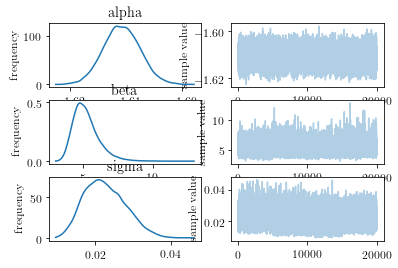

In [82]:
fit.plot()
plt.show()

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


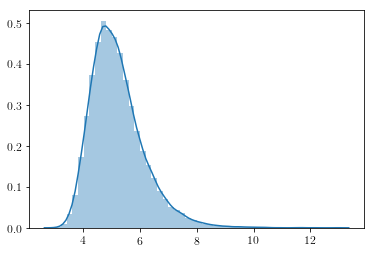

In [83]:
sns.distplot(fit['beta'])

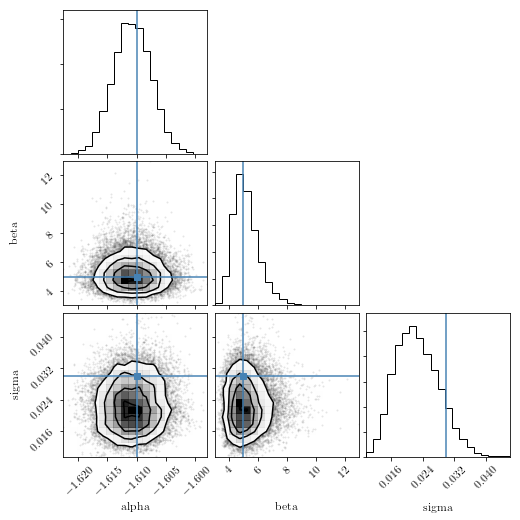

In [84]:
import corner
data = np.vstack([fit['alpha'], fit['beta'], fit['sigma']]).T
corner.corner(data, labels=['alpha', 'beta', 'sigma'], truths=[alpha, 1.0/betainv, RCS])
plt.show()

Comments TODO